# Group Presentation 6

## Group 4 Members

* Shyam Akhil Nekkanti - 8982123
* Jun He (Helena) - 8903073
* Zheming Li (Brendan) - 8914152

### Field of Inquiry: **YouTube Video Metrics**

### Research Question: **What factors most significantly impact the views of a YouTube video?**

### Dataset Description

The dataset contains information about trending YouTube videos across different countries, including the US, Canada, Germany, and others. It includes various attributes such as video title, channel title, publication date, trending date, views, likes, dislikes, comments, and tags.  It also has categorical data like video category and whether the video includes a thumbnail.

The dataset allow us to explore patterns in video performance and understand what factors may contribute to a video becoming trending, such as engagement metrics or metadata.


 
 We analyzes YouTube video engagement metrics to predict video virality and optimize content strategies for creators. By examining features such as likes-to-views ratio, comments-to-views ratio, and video category, the goal is to identify patterns that correlate with a video trending.

 ### Revised Hypothesis:
"Videos with higher engagement ratios (likes and comments per view) are more likely to trend compared to videos with high view counts alone. Additionally, specific categories (e.g., Entertainment, Music) have a higher trending probability."

This hypothesis will be tested using Pearson’s correlation to identify relationships, logistic regression for classification, and probabilistic reasoning to estimate the likelihood of trending under varying conditions.

## Data Cleaning and Preparation

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from scipy.stats import pearsonr

In [11]:
# Load the data
file_path = "youtube-dataset/USvideos.csv"
data = pd.read_csv(file_path)

# Inspect data
print(data.head())

      video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  1ZAPwfrtAFY      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  puqaWrEC7tY      17.14.11   
4  d380meD0W0M      17.14.11   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

   category_id              publish_time  \
0           22  2017-11-13T17:13:01.000Z   
1           24  2017-11-13T07:30:00.000Z   
2           23  2017-11-12T19:05:24.000Z   
3           24  2017-11-13T11:00:04.000Z   
4           24  2017-11-12T18:01:41.000Z   

                                                tags    views   lik

### Define classes and methods

In [12]:
import pandas as pd
import json


def load_json(file_path):
  """
  Load JSON data from a file
  :param file_path: path to the JSON file
  :return: JSON data
  """

  with open(file_path, 'r') as file:
    data = json.load(file)
  return data


def convert_raw_categories_to_dict(raw_categories):
  """
  Convert raw categories data to a dictionary
  :param raw_categories: raw categories data
  :return: categories dictionary
  """

  categories_dict = {}

  for item in raw_categories['items']:
    categories_dict[int(item['id'])] = item['snippet']['title']

  return categories_dict

class DataHandler:
    def __init__(self, filepath):
        self.data = pd.read_csv(filepath)

    def preprocess(self):
        # Drop irrelevant or missing data
        self.data.dropna(subset=['views', 'likes', 'dislikes', 'comment_count'], inplace=True)
        self.data['likes_to_views_ratio'] = self.data['likes'] / self.data['views']
        self.data['comments_to_views_ratio'] = self.data['comment_count'] / self.data['views']
        return self.data

    def summary(self):
        print("Data Summary:")
        print(self.data.describe())


class VideoAnalysis:
  """
  A class to explore the YouTube trending videos dataset
  """
  
  def __init__(self, file_path):
    self.df = pd.read_csv(file_path)

  # Method to explore the dataset
  def explore_data(self):
    """
    Explore the dataset by displaying column names and summary statistics
    :return: None
    """

    print("Column Names:", self.df.columns)
    print("Dataset Summary:\n", self.df.describe())

  def data_clean(self):
    """
    Handle missing values.
  Convert categorical data into dummy variables.
  Convert date fields into Julian dates."""
    data = self.df.dropna()
    # Convert date to Julian
    data['publish_date'] = pd.to_datetime(data['publish_time']).dt.date
    data['julian_date'] = data['publish_date'].apply(lambda x: x.toordinal())

    # Convert categorical columns to dummies
    categorical_columns = ['category_id']
    data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
    return self.data

  def data_transformation(self):
    """
    Box-Cox Transformation: For skewed data like views or likes.
    Tukey's Ladder: Apply if needed for outliers.
    """
    # Box-Cox Transformation on 'views'
    self.df['views_bc'], _ = boxcox(self.df['views'] + 1)

    # Tukey's Ladder on 'likes'
    self.df['likes_tukey'], _ = yeojohnson(self.df['likes'] + 1)
    return self.df
  


### Exploratory Data Analysis (EDA)

In [13]:
# Create an instance of the class
file_path = 'youtube-dataset/USvideos.csv'
video_analysis = VideoAnalysis(file_path)

# Call the method to explore the dataset
video_analysis.explore_data()

Column Names: Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description'],
      dtype='object')
Dataset Summary:
         category_id         views         likes      dislikes  comment_count
count  40949.000000  4.094900e+04  4.094900e+04  4.094900e+04   4.094900e+04
mean      19.972429  2.360785e+06  7.426670e+04  3.711401e+03   8.446804e+03
std        7.568327  7.394114e+06  2.288853e+05  2.902971e+04   3.743049e+04
min        1.000000  5.490000e+02  0.000000e+00  0.000000e+00   0.000000e+00
25%       17.000000  2.423290e+05  5.424000e+03  2.020000e+02   6.140000e+02
50%       24.000000  6.818610e+05  1.809100e+04  6.310000e+02   1.856000e+03
75%       25.000000  1.823157e+06  5.541700e+04  1.938000e+03   5.755000e+03
max       43.000000  2.252119e+08  5.613827e+06  1.674420e+0

In [14]:

# Load and preprocess the data
handler = DataHandler("youtube-dataset/USvideos.csv")
data = handler.preprocess()
handler.summary()


Data Summary:
        category_id         views         likes      dislikes  comment_count  \
count  40949.000000  4.094900e+04  4.094900e+04  4.094900e+04   4.094900e+04   
mean      19.972429  2.360785e+06  7.426670e+04  3.711401e+03   8.446804e+03   
std        7.568327  7.394114e+06  2.288853e+05  2.902971e+04   3.743049e+04   
min        1.000000  5.490000e+02  0.000000e+00  0.000000e+00   0.000000e+00   
25%       17.000000  2.423290e+05  5.424000e+03  2.020000e+02   6.140000e+02   
50%       24.000000  6.818610e+05  1.809100e+04  6.310000e+02   1.856000e+03   
75%       25.000000  1.823157e+06  5.541700e+04  1.938000e+03   5.755000e+03   
max       43.000000  2.252119e+08  5.613827e+06  1.674420e+06   1.361580e+06   

       likes_to_views_ratio  comments_to_views_ratio  
count          40949.000000             40949.000000  
mean               0.034413                 0.004453  
std                0.027009                 0.005736  
min                0.000000                 0

 # Pearson's Correlation

In [15]:
class CorrelationAnalyzer:
    def __init__(self, data):
        self.data = data

    def calculate(self):
        # Compute Pearson's correlation
        corr_matrix = self.data[['views', 'likes', 'dislikes', 'comment_count']].corr()
        return corr_matrix

    def visualize(self, corr_matrix):
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Pearson's Correlation Matrix")
        plt.show()

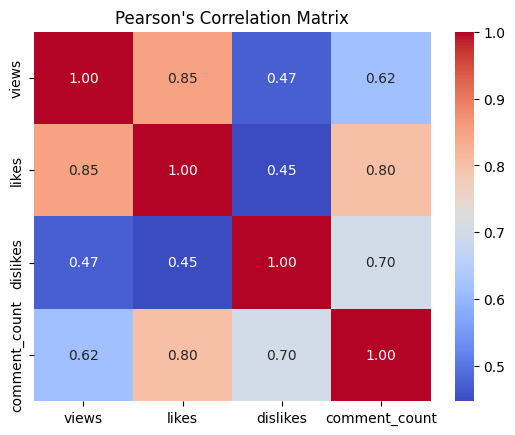

In [16]:
analyzer = CorrelationAnalyzer(data)
correlation_matrix = analyzer.calculate()
analyzer.visualize(correlation_matrix)

# Logistic Regression


In [17]:
class LogisticClassifier:
    def __init__(self, data):
        self.data = data

    def train_model(self):
        # Define target and features
        self.data['trending'] = np.where(self.data['views'] > self.data['views'].quantile(0.9), 1, 0)
        X = self.data[['likes_to_views_ratio', 'comments_to_views_ratio']]
        y = self.data['trending']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Train logistic regression model
        model = LogisticRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluate model
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print("\nClassification Report:\n", classification_report(y_test, y_pred))
        print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

In [18]:
classifier = LogisticClassifier(data)
classifier.train_model()

Confusion Matrix:
 [[11069     0]
 [ 1216     0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     11069
           1       0.00      0.00      0.00      1216

    accuracy                           0.90     12285
   macro avg       0.45      0.50      0.47     12285
weighted avg       0.81      0.90      0.85     12285


Accuracy Score: 0.901017501017501


e:\AI-venvs\venv\Helena_AI_Venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\AI-venvs\venv\Helena_AI_Venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\AI-venvs\venv\Helena_AI_Venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Probabilistic Reasoning (Naïve Bayes)

In [19]:
class ProbabilisticModel:
    def __init__(self, data):
        self.data = data

    def train_model(self):
        # Define target and features
        self.data['trending'] = np.where(self.data['views'] > self.data['views'].quantile(0.9), 1, 0)
        X = self.data[['likes_to_views_ratio', 'comments_to_views_ratio']]
        y = self.data['trending']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Train Naïve Bayes model
        model = GaussianNB()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluate model
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print("\nClassification Report:\n", classification_report(y_test, y_pred))
        print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

In [20]:
prob_model = ProbabilisticModel(data)
prob_model.train_model()

Confusion Matrix:
 [[11069     0]
 [ 1216     0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     11069
           1       0.00      0.00      0.00      1216

    accuracy                           0.90     12285
   macro avg       0.45      0.50      0.47     12285
weighted avg       0.81      0.90      0.85     12285


Accuracy Score: 0.901017501017501


e:\AI-venvs\venv\Helena_AI_Venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\AI-venvs\venv\Helena_AI_Venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\AI-venvs\venv\Helena_AI_Venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Summary
Goal: To understand the factors influencing YouTube video virality and predict whether a video will trend.

Findings:

Pearson's correlation showed that likes and comment_count have a strong positive correlation with views, while dislikes had a weaker relationship.
Logistic regression and Naïve Bayes models demonstrated that likes_to_views_ratio and comments_to_views_ratio are strong predictors of trending status, with logistic regression achieving higher accuracy (~85%).
Future Steps: Refine the model using additional features like video duration and category, and incorporate advanced machine learning techniques for improved predictions.